# NLP - Assignment 2

## Imports

In [1]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from FuzzyTM import FLSA_W
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim
from gensim import corpora

c:\Users\bravo\anaconda3\envs\JADS-NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [2]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv("./us_equities_news_dataset.csv")
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [3]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]

In [4]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the default stop words
default_stop_words = set(stopwords.words('english'))

def preprocess_text(text,
                    remove_punctuation=True,
                    remove_stopwords=True,
                    lemmatize=False,
                    remove_short_words=False,
                    remove_numbers=True,
                    min_word_length=2,
                    top_n_percent=0,
                    bottom_n_percent=0,
                    remove_words=None,  # specific words to remove
                    meaningful_words=None  # meaningful words to keep
                   ):
    """
    Advanced preprocessing function that applies different levels of text processing.

    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    - top_n_percent: Percentage of the most frequent words to remove.
    - bottom_n_percent: Percentage of the least frequent words to remove.
    - remove_words: A list of specific words to remove.
    - meaningful_words: A list of meaningful words to exclude from stop words.

    Returns:
    - Preprocessed text as tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Remove stopwords, excluding meaningful words
    if remove_stopwords:
        stop_words = default_stop_words
        if meaningful_words:
            stop_words = stop_words - set(meaningful_words)  # Exclude meaningful words from stop words
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]

    # Calculate global word frequencies
    global_word_frequencies = Counter(tokens)

    # Remove top n% most frequent words
    if top_n_percent > 0:
        top_n_cutoff = int(len(global_word_frequencies) * (top_n_percent / 100))
        top_n_words = {word for word, count in global_word_frequencies.most_common(top_n_cutoff)}
        tokens = [token for token in tokens if token not in top_n_words]

    # Remove bottom n% least frequent words
    if bottom_n_percent > 0:
        bottom_n_cutoff = int(len(global_word_frequencies) * (bottom_n_percent / 100))
        bottom_n_words = {word for word, count in global_word_frequencies.most_common()[:-bottom_n_cutoff-1:-1]}
        tokens = [token for token in tokens if token not in bottom_n_words]

    # Remove specific words
    if remove_words:
        tokens = [token for token in tokens if token not in remove_words]

    return tokens

In [6]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.

    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').

    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """
    
    # Make a copy of the dataset for each version to avoid overwriting the original content
    dataset_copy = nvidia_dataset.copy()

    if version == 'v1':
        # Basic tokenization and lowercasing
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=False, 
            remove_stopwords=False,
            lemmatize=False, 
            remove_numbers=False,
            remove_short_words=False,
            top_n_percent=0,
            bottom_n_percent=0,
        ))

    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=True, 
            remove_stopwords=True,
            lemmatize=False, 
            remove_numbers=True,
            remove_short_words=False,
            top_n_percent=5,
            bottom_n_percent=5,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down']
        ))

    elif version == 'v3':
        # Full preprocessing with lemmatization, number removal, and short words removal
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=True, 
            remove_stopwords=True,
            lemmatize=True, 
            remove_numbers=True,
            remove_short_words=True, 
            min_word_length=2,
            top_n_percent=5,
            bottom_n_percent=5,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down', 'through', 'during', 'before', 'after', 'above', 'below']
        ))

    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3'")

    # Return a separate DataFrame for each version with preprocessed content
    return dataset_copy


In [7]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with lemmatizer

train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,A Central Bank War Just Started And Its Good F...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[a, central, bank, war, just, started, and, it..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch Nivida Could Be Falling 6 S...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[6, stocks, to, watch, nivida, could, be, fall..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Stocks Dow Drops Nearly 400 Points as Apple ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[stocks, dow, drops, nearly, 400, points, as, ..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,The Zacks Analyst Blog Highlights Advanced Mi...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[the, zacks, analyst, blog, highlights, advanc..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,The Best Of CES 2020 Revised With 4 500 comp...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[the, best, of, ces, 2020, revised, with, 4, 5..."


In [8]:
unique_words_v1 = set([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
unique_words_v2 = set([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
unique_words_v3 = set([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

print("Unique words in v1:", len(unique_words_v1))
print("Unique words in v2:", len(unique_words_v2))
print("Unique words in v3:", len(unique_words_v3))

Unique words in v1: 36322
Unique words in v2: 31468
Unique words in v3: 28459


In [9]:
# Flatten lists and count word frequencies
freq_v1 = Counter([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
freq_v2 = Counter([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
freq_v3 = Counter([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

# Print the most common words side by side for easier comparison
def print_side_by_side(freq_v1, freq_v2, freq_v3, top_n=10):
    print(f"{'Rank':<5} {'v1':<20} {'Count':<10} {'v2':<20} {'Count':<10} {'v3':<20} {'Count':<10}")
    print("="*100)
    for i, ((word1, count1), (word2, count2), (word3, count3)) in enumerate(zip(freq_v1.most_common(top_n), freq_v2.most_common(top_n), freq_v3.most_common(top_n)), 1):
        print(f"{i:<5} {word1:<20} {count1:<10} {word2:<20} {count2:<10} {word3:<20} {count3:<10}")

print_side_by_side(freq_v1, freq_v2, freq_v3)

Rank  v1                   Count      v2                   Count      v3                   Count     
1     the                  126904     nasdaq               4084       nasdaq               4311      
2     to                   61701      also                 3961       share                4105      
3     and                  55488      up                   3915       also                 4090      
4     of                   54474      market               3589       up                   3990      
5     in                   46306      stocks               3436       market               3463      
6     a                    44793      stock                3181       stock                3386      
7     s                    32960      expected             3125       expected             3226      
8     is                   26139      shares               3111       growth               3184      
9     for                  24701      growth               3022       company     

In [10]:
# Flatten the list of lists to get a single list of words
all_tokens_v3 = [word for sublist in train_data_v3['preprocessed_content'] for word in sublist]

# Get the 50 most common words
common_words_v3 = Counter(all_tokens_v3).most_common(50)

# Print the most common 50 words and their respective frequencies
print('Most common 50 words and respective frequencies:\n')
for i, (word, freq) in enumerate(common_words_v3, 1):
    print(f'{i:<2}- {word:<15} {freq}')

Most common 50 words and respective frequencies:

1 - nasdaq          4311
2 - share           4105
3 - also            4090
4 - up              3990
5 - market          3463
6 - stock           3386
7 - expected        3226
8 - growth          3184
9 - company         3160
10- new             3110
11- buy             3098
12- last            3096
13- strong          3054
14- nyse            2996
15- year            2984
16- billion         2983
17- top             2874
18- high            2849
19- rank            2847
20- technology      2844
21- time            2838
22- see             2824
23- one             2817
24- investor        2786
25- price           2743
26- per             2655
27- earnings        2650
28- inc             2574
29- estimate        2572
30- like            2565
31- revenue         2479
32- after           2469
33- report          2447
34- well            2316
35- day             2314
36- result          2313
37- quarter         2306
38- product         2291


In [11]:
print(f"Number of unique words: {len(set(all_tokens_v3)):,}")
print(f"Lexical richness: {len(set(all_tokens_v3))/len(all_tokens_v3):.4f}")

Number of unique words: 28,459
Lexical richness: 0.0271


## Helper functions

In [12]:
def remove_top_bottom_words(preprocessed_content, top_percent=10, bottom_percent=10, words_to_exclude=None):
    """
    Remove top-n% and bottom-n% words based on frequency and exclude specified words.

    Parameters:
    - preprocessed_content: list of lists, the preprocessed content
    - top_percent: int, the top n% of words to remove
    - bottom_percent: int, the bottom n% of words to remove
    - words_to_exclude: set, the words to exclude

    Returns:
    - list of lists, the content with specified words removed
    """
    # Flatten the list of lists to get a single list of words
    all_words = [word for sublist in preprocessed_content for word in sublist]
    
    # Get the word frequencies
    word_freq = Counter(all_words)
    
    # Calculate the number of words to remove
    total_words = len(word_freq)
    top_n = int(total_words * top_percent / 100)
    bottom_n = int(total_words * bottom_percent / 100)
    
    # Get the top-n% and bottom-n% words
    top_words = set([word for word, freq in word_freq.most_common(top_n)])
    bottom_words = set([word for word, freq in word_freq.most_common()[:-bottom_n-1:-1]])
    
    # Combine the words to exclude
    words_to_remove = top_words | bottom_words
    if words_to_exclude:
        words_to_remove |= words_to_exclude
    
    # Remove the specified words from the content
    filtered_content = [[word for word in sublist if word not in words_to_remove] for sublist in preprocessed_content]
    
    return filtered_content

### LDA

### FLSA-W

In [13]:
def compute_coherence_flsa_w(train_data, max_topics=10, num_words_list=[5, 7, 10]):
    """
    Compute coherence scores for FLSA-W model with varying number of topics and words per topic.
    
    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
        - num_words_list: list of int, different numbers of words per topic to test.
    
    Returns:
        - results: list of tuples, each containing (num_topics, num_words, coherence_score).
    """
    
    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]
    
    results = []
    
    # Loop through each number of words per topic first
    for num_words in num_words_list:
        # Loop through each number of topics for the current number of words
        for num_topics in range(2, max_topics + 1):
            # Train FLSA-W model
            flsa_w_model = FLSA_W(
                input_file=tokenized_data,  
                num_topics=num_topics,      
                num_words=num_words               
            )
            
            # Train the FLSA-W model
            flsa_w_model.get_matrices()  
            
            # Get the coherence score for the current model
            coherence_score = flsa_w_model.get_coherence_score() 
            print(f"Number of topics: {num_topics}, Number of words: {num_words}, Coherence score: {coherence_score:.4f}")
            
            # Store the results
            results.append((num_topics, num_words, coherence_score))
    
    return results

In [14]:
def compute_coherence_flsa_w(train_data, max_topics=10, num_words_list=[5, 7, 10]):
    """
    Compute coherence scores for FLSA-W model with varying number of topics and words per topic.
    
    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
        - num_words_list: list of int, different numbers of words per topic to test.
        - display: bool, if True, will print the results in a structured format per num_words.
    
    Returns:
        - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """
    
    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]
    
    results = []
    
    # Loop through each number of words per topic first
    for num_words in num_words_list:
        print(f"\n=== Results for {num_words} words per topic ===")
        
        # Loop through each number of topics for the current number of words
        for num_topics in range(2, max_topics + 1):
            # Train FLSA-W model with the current num_words and num_topics
            flsa_w_model = FLSA_W(
                input_file=tokenized_data,  
                num_topics=num_topics,      
                num_words=num_words               
            )
            
            # Train the FLSA-W model
            flsa_w_model.get_matrices()  
            
            # Get the coherence score for the current model
            coherence_score = flsa_w_model.get_coherence_score() 
            
            # Store the results as a tuple (num_words, num_topics, coherence_score)
            results.append((num_words, num_topics, coherence_score))

            print(f"Number of topics: {num_topics}, Coherence score: {coherence_score:.4f}")
    
    return results


In [15]:
def plot_elbow_curve(results):
    """
    Create elbow plots for coherence scores vs. number of topics for different num_words.
    
    Parameters:
    - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """
    # Organize results by num_words
    num_words_dict = {}
    for num_words, num_topics, coherence_score in results:  # Corrected tuple unpacking order
        if num_words not in num_words_dict:
            num_words_dict[num_words] = {'num_topics': [], 'coherence_scores': []}
        num_words_dict[num_words]['num_topics'].append(num_topics)
        num_words_dict[num_words]['coherence_scores'].append(coherence_score)
    
    # Plot each num_words line
    plt.figure(figsize=(10, 6))
    for num_words, data in num_words_dict.items():
        plt.plot(data['num_topics'], data['coherence_scores'], marker='o', label=f'Num words: {num_words}')
    
    # Add plot labels and title
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score for Different Number of Words per Topic')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(title='Words per Topic')
    plt.grid(True)
    plt.show()

### BERTopic

In [16]:
def print_bertopic_topics(topic_model):
    """
    Print topics generated by BERTopic.

    Parameters:
    - topic_model: the trained BERTopic model
    """
    topics = topic_model.get_topics()
    for topic_num, words in topics.items():
        # Ignore the '-1' topic, which is typically noise in BERTopic
        if topic_num == -1:
            continue
        print(f"Topic {topic_num}: {', '.join([word[0] for word in words])}")

## Elbow Plot

In [17]:
# Set seed for reproducible results
np.random.seed(42)

# Train the model and compute coherence scores
results = compute_coherence_flsa_w(train_data_v3, max_topics=15, num_words_list=[5, 7, 10]) # TODO: FYI only did this for v3


=== Results for 5 words per topic ===
Number of topics: 2, Coherence score: 0.4843
Number of topics: 3, Coherence score: 0.4709
Number of topics: 4, Coherence score: 0.5673
Number of topics: 5, Coherence score: 0.4647
Number of topics: 6, Coherence score: 0.5034
Number of topics: 7, Coherence score: 0.4796
Number of topics: 8, Coherence score: 0.5052
Number of topics: 9, Coherence score: 0.3859
Number of topics: 10, Coherence score: 0.4017
Number of topics: 11, Coherence score: 0.4275
Number of topics: 12, Coherence score: 0.3813
Number of topics: 13, Coherence score: 0.4322
Number of topics: 14, Coherence score: 0.3898
Number of topics: 15, Coherence score: 0.4045

=== Results for 7 words per topic ===
Number of topics: 2, Coherence score: 0.4331
Number of topics: 3, Coherence score: 0.3835
Number of topics: 4, Coherence score: 0.4559
Number of topics: 5, Coherence score: 0.3996
Number of topics: 6, Coherence score: 0.4185
Number of topics: 7, Coherence score: 0.4136
Number of topics

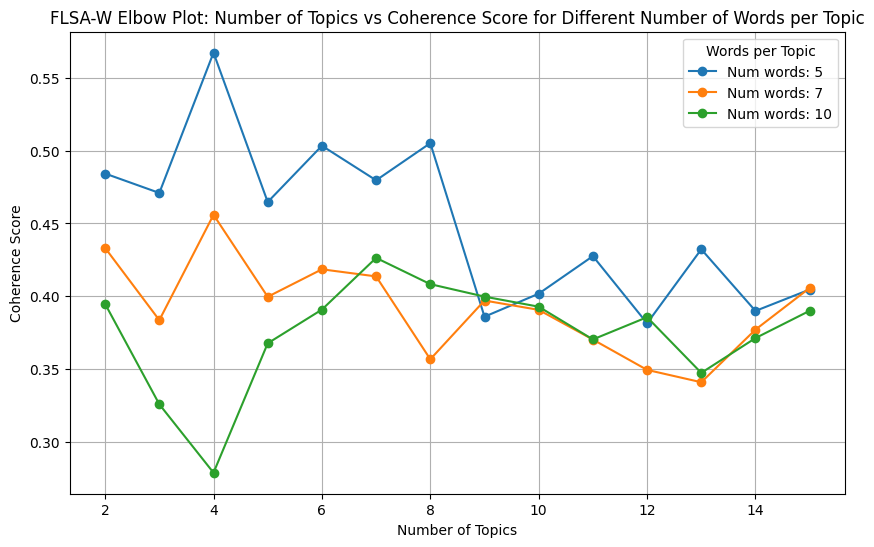

In [18]:
# Plot the elbow curve
plot_elbow_curve(results)

## Train Topic Models

In [35]:
# the optimal number of topics according to FLSA-W
NUMBER_OF_TOPICS = 8

In [36]:
def train_topic_model(train_data, model_type='LDA', num_topics=NUMBER_OF_TOPICS, preprocess=False, words_to_exclude=None):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: list of str, the text to train the model on
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - num_topics: int, the number of topics to use for the model
    - preprocess: bool, whether to preprocess the data using remove_top_bottom_words
    - words_to_exclude: list of str, specific words to exclude from the data

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    """

    train_data_list_string = [' '.join(tokens) for tokens in train_data['preprocessed_content']]
    train_data_list_tokens = train_data['preprocessed_content'].tolist()  

    if preprocess and words_to_exclude:
        train_data_list_tokens = remove_top_bottom_words(
            train_data_list_tokens,
            top_percent=0,  # No top words removal
            bottom_percent=0,  # No bottom words removal
            words_to_exclude=words_to_exclude
        )
        train_data_list_string = [' '.join(tokens) for tokens in train_data_list_tokens]

    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=5,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=5)

        return lda_model, topics

    elif model_type == 'FLSA-W':
        flsa_w_model = FLSA_W(
            input_file=train_data_list_tokens,
            num_topics=num_topics,
            num_words=5
        )
        pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model
        topics = flsa_w_model.show_topics(representation='words')

        return flsa_w_model, topics
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic()
        topics, _ = topic_model.fit_transform(train_data_list_string)

        return topic_model, topics

    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

## Evaluation

### Qualitative

In [21]:
def inspect_model(topic_model):
    """
    Inspect the topics generated by a trained topic model.

    Parameters:
    - topic_model: the trained topic model.
    """
    return topic_model.get_topics(), topic_model.get_info(), topic_model.get_topic_embeddings(), topic_model.get_vocabulary(), topic_model.get_vocabulary_size() # TODO: decide on metrics

### Quantitative

In [22]:
def evaluate_model(topic_model):
    """
    Evaluate the quality of a trained topic model using various metrics.

    Parameters:
    - topic_model: the trained topic model.
    """
    return topic_model.get_coherence_score(), topic_model.get_diversity_score(), topic_model.get_interpretability_score() # TODO: decide which metric (I think we only need coherence)

## Iteration 1

### LDA

In [37]:
LDA_model, LDA_topics = train_topic_model(train_data_v1[0:10], model_type='LDA', num_topics=NUMBER_OF_TOPICS, preprocess=False)

# Print topics
for topic in LDA_topics:
    print(topic)

(0, '0.008*"the" + 0.007*"and" + 0.005*"to" + 0.005*"of" + 0.005*"in"')
(1, '0.040*"the" + 0.027*"and" + 0.023*"a" + 0.019*"of" + 0.018*"to"')
(2, '0.006*"the" + 0.005*"to" + 0.003*"and" + 0.003*"of" + 0.003*"in"')
(3, '0.050*"the" + 0.022*"to" + 0.022*"of" + 0.018*"and" + 0.016*"in"')
(4, '0.008*"the" + 0.006*"to" + 0.004*"and" + 0.004*"of" + 0.004*"a"')
(5, '0.013*"the" + 0.007*"to" + 0.006*"a" + 0.006*"and" + 0.005*"of"')
(6, '0.014*"the" + 0.006*"of" + 0.006*"and" + 0.006*"to" + 0.005*"a"')
(7, '0.048*"the" + 0.029*"to" + 0.022*"of" + 0.020*"and" + 0.019*"in"')


### FLSA-W

In [ ]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics = train_topic_model(train_data_v1, model_type='FLSA-W', num_topics=NUMBER_OF_TOPICS, preprocess=False)

# Show the topics generated
print("FLSA-W Topics with Word Probabilities:\n")
for topic in flsa_w_model.show_topics():
    print(topic)

# Print topics with improved formatting
print("\n\nFLSA-W Topics:\n")
for i, topic in enumerate(flsa_w_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

# Show topic quality scores
print("\nCoherence Score:", round(flsa_w_model.get_coherence_score(), 4))
print("Diversity Score:", round(flsa_w_model.get_diversity_score(), 4))
print("Interpretability Score:", round(flsa_w_model.get_interpretability_score(), 4))

FLSA-W Topics with Word Probabilities:

(0, '0.0005*"rises" + 0.0004*"premarket" + 0.0003*"178" + 0.0003*"nellis" + 0.0003*"mcqueeney"')
(1, '0.0005*"miners" + 0.0004*"falls" + 0.0004*"towards" + 0.0004*"o" + 0.0004*"insiders"')
(2, '0.0017*"broader" + 0.0017*"com" + 0.0016*"27" + 0.0015*"23" + 0.0015*"intc"')
(3, '0.001*"reuters" + 0.0009*"traded" + 0.0008*"autonomous" + 0.0008*"proven" + 0.0008*"previously"')
(4, '0.0025*"episode" + 0.0023*"newest" + 0.0022*"becoming" + 0.0021*"actions" + 0.0021*"technological"')
(5, '0.0002*"8800" + 0.0002*"0000" + 0.0002*"reiterates" + 0.0002*"174" + 0.0002*"delisting"')
(6, '0.0115*"book" + 0.0115*"evolution" + 0.0095*"books" + 0.0092*"certainty" + 0.0088*"richard"')
(7, '0.0058*"nvda" + 0.0051*"nasdaq" + 0.005*"stock" + 0.0048*"technology" + 0.0045*"10"')


FLSA-W Topics:

Topic 1: rises, premarket, 178, nellis, mcqueeney
Topic 2: miners, falls, towards, o, insiders
Topic 3: broader, com, 27, 23, intc
Topic 4: reuters, traded, autonomous, proven,

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v1, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

## Iteration 2

### LDA

In [39]:
LDA_model_v2, LDA_topics_v2 = train_topic_model(train_data_v2[0:10], model_type='LDA', num_topics=NUMBER_OF_TOPICS, preprocess=False)

# Print topics
for topic in LDA_topics_v2:
    print(topic)

(0, '0.006*"like" + 0.006*"next" + 0.006*"also" + 0.005*"nyse" + 0.005*"technology"')
(1, '0.001*"full" + 0.001*"also" + 0.001*"next" + 0.001*"fleet" + 0.001*"nyse"')
(2, '0.004*"down" + 0.004*"strong" + 0.004*"p" + 0.004*"best" + 0.004*"investors"')
(3, '0.001*"software" + 0.001*"better" + 0.001*"design" + 0.001*"lens" + 0.001*"based"')
(4, '0.001*"water" + 0.001*"see" + 0.001*"lens" + 0.001*"based" + 0.001*"group"')
(5, '0.004*"group" + 0.004*"based" + 0.004*"software" + 0.004*"option" + 0.004*"better"')
(6, '0.004*"see" + 0.004*"line" + 0.004*"regulatory" + 0.004*"decline" + 0.004*"business"')
(7, '0.007*"company" + 0.005*"day" + 0.005*"today" + 0.005*"worth" + 0.005*"tesla"')


In [40]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics = train_topic_model(train_data_v2, model_type='FLSA-W', num_topics=NUMBER_OF_TOPICS, preprocess=True, words_to_exclude={'gmt', 'inc', 'com'})

# Show the topics generated
print("FLSA-W Topics with Word Probabilities:\n")
for topic in flsa_w_model.show_topics():
    print(topic)

# Print topics with improved formatting
print("\n\nFLSA-W Topics:\n")
for i, topic in enumerate(flsa_w_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

# Show topic quality scores
print("\nCoherence Score:", round(flsa_w_model.get_coherence_score(), 4))
print("Diversity Score:", round(flsa_w_model.get_diversity_score(), 4))
print("Interpretability Score:", round(flsa_w_model.get_interpretability_score(), 4))

FLSA-W Topics with Word Probabilities:

(0, '0.0032*"nasdaq" + 0.0031*"year" + 0.0031*"company" + 0.003*"stocks" + 0.0028*"stock"')
(1, '0.0006*"rises" + 0.0005*"premarket" + 0.0004*"troy" + 0.0004*"" + 0.0003*"smh"')
(2, '0.0009*"traded" + 0.0008*"cryptocurrency" + 0.0008*"revolutions" + 0.0008*"commodities" + 0.0007*"blast"')
(3, '0.0096*"beliefs" + 0.0087*"synthesis" + 0.0082*"creativity" + 0.0077*"destiny" + 0.0074*"motorcycle"')
(4, '0.0083*"theory" + 0.0078*"century" + 0.0068*"art" + 0.0062*"channels" + 0.006*"written"')
(5, '0.0005*"outnumbered" + 0.0005*"slumped" + 0.0005*"implied" + 0.0004*"performers" + 0.0004*"strategiesit"')
(6, '0.0013*"mu" + 0.0013*"chipmaker" + 0.0013*"rose" + 0.0013*"points" + 0.0013*"corp"')
(7, '0.0002*"delisting" + 0.0002*"supervisory" + 0.0002*"reiterates" + 0.0002*"whileolympusshares" + 0.0002*"upnoteus"')


FLSA-W Topics:

Topic 1: nasdaq, year, company, stocks, stock
Topic 2: rises, premarket, troy, , smh
Topic 3: traded, cryptocurrency, revoluti

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v2, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

## Iteration 3

### LDA

In [41]:
LDA_model_v3, LDA_topics_v3 = train_topic_model(train_data_v3[0:10], model_type='LDA', num_topics=NUMBER_OF_TOPICS, preprocess=False)

# Print topics
for topic in LDA_topics_v3:
    print(topic)

(0, '0.001*"level" + 0.001*"up" + 0.001*"day" + 0.001*"get" + 0.001*"like"')
(1, '0.006*"rise" + 0.006*"today" + 0.006*"tesla" + 0.006*"think" + 0.006*"right"')
(2, '0.001*"also" + 0.001*"like" + 0.001*"research" + 0.001*"giant" + 0.001*"report"')
(3, '0.005*"down" + 0.005*"investor" + 0.004*"low" + 0.004*"end" + 0.004*"time"')
(4, '0.006*"china" + 0.006*"company" + 0.006*"share" + 0.005*"president" + 0.005*"dow"')
(5, '0.001*"service" + 0.001*"price" + 0.001*"down" + 0.001*"time" + 0.001*"drive"')
(6, '0.004*"make" + 0.004*"based" + 0.004*"inch" + 0.004*"group" + 0.004*"phone"')
(7, '0.006*"next" + 0.006*"like" + 0.006*"also" + 0.006*"fleet" + 0.006*"automated"')


### FLSA-W

In [42]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics = train_topic_model(train_data_v3, model_type='FLSA-W', num_topics=NUMBER_OF_TOPICS, preprocess=True, words_to_exclude={'gmt', 'inc', 'com', 'googl', 'amat', 'et'})

# Show the topics generated
print("FLSA-W Topics with Word Probabilities:\n")
for topic in flsa_w_model.show_topics():
    print(topic)

# Print topics with improved formatting
print("\n\nFLSA-W Topics:\n")
for i, topic in enumerate(flsa_w_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

# Show topic quality scores
print("\nCoherence Score:", round(flsa_w_model.get_coherence_score(), 4))
print("Diversity Score:", round(flsa_w_model.get_diversity_score(), 4))
print("Interpretability Score:", round(flsa_w_model.get_interpretability_score(), 4))

FLSA-W Topics with Word Probabilities:

(0, '0.0002*"reiterates" + 0.0002*"delisting" + 0.0002*"supervisory" + 0.0002*"upnoteus" + 0.0002*"whileolympusshares"')
(1, '0.0005*"premarket" + 0.0005*"troy" + 0.0004*"smh" + 0.0003*"nellis" + 0.0003*"mcqueeney"')
(2, '0.0035*"market" + 0.0035*"nasdaq" + 0.0033*"share" + 0.0032*"stock" + 0.0031*"technology"')
(3, '0.0017*"corp" + 0.0016*"session" + 0.0015*"rose" + 0.0015*"zacks" + 0.0015*"fell"')
(4, '0.0011*"traded" + 0.0009*"blast" + 0.0009*"cryptocurrency" + 0.0009*"mining" + 0.0008*"elsewhere"')
(5, '0.0006*"performer" + 0.0005*"settle" + 0.0005*"slumped" + 0.0005*"implied" + 0.0005*"remarkably"')
(6, '0.0088*"theory" + 0.0085*"century" + 0.0069*"scientist" + 0.0067*"education" + 0.0065*"author"')
(7, '0.0096*"synthesis" + 0.0089*"creativity" + 0.0086*"crispr" + 0.0083*"destiny" + 0.008*"professor"')


FLSA-W Topics:

Topic 1: reiterates, delisting, supervisory, upnoteus, whileolympusshares
Topic 2: premarket, troy, smh, nellis, mcqueeney


### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v3, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

Topic Similarity Matrix

In [ ]:
bertopic_model.visualize_heatmap()

## Output of Final Topic Model